# **DoorDash Analytics Case Study:**

## **Introduction**
The objective of this analysis is to examine the provided dataset and generate specific recommendations on how DoorDash can improve its business operations. This involves analyzing key metrics and providing supporting analysis while stating the assumptions made during the process.

Dataset Overview
The dataset includes the following information:

* Customer order time
* Restaurant order time
* Driver arrival at restaurant time
* Order delivery time
* Driver ID
* Customer ID
* Amount of discount
* Amount of tip


After researching, it was determined that the north star metric for DoorDash is the Number of completed deliveries. This analysis focuses on this metric to provide business recommendations aimed at improving it.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/Analytics_Sample_Data_rsc.csv")

In [ ]:
df.head()

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0


Here the first step I am doing is getting details about the dataset so that I can figure out what all preprocessing and cleaning steps I need to take for an efficient analysis. Here you can see that most of the columns have 18078 rows of data but there are some columns such as ***Placed_order_with_restaurant_datetime*** which have 18038 non null data, which shows that there are some null data present.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18078 entries, 0 to 18077
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer_placed_order_datetime         18078 non-null  object 
 1   Placed_order_with_restaurant_datetime  18038 non-null  object 
 2   Driver_at_restaurant_datetime          13547 non-null  object 
 3   Delivered_to_consumer_datetime         18078 non-null  object 
 4   Driver_ID                              18078 non-null  int64  
 5   Restaurant_ID                          18078 non-null  int64  
 6   Consumer_ID                            18078 non-null  int64  
 7   Is_New                                 18078 non-null  bool   
 8   Delivery_Region                        18052 non-null  object 
 9   Is_ASAP                                18078 non-null  bool   
 10  Order_total                            18078 non-null  float64
 11  Am

To prepare the dataset for analysis, missing values in the Placed_order_with_restaurant_datetime and Driver_at_restaurant_datetime columns were filled using linear interpolation based on the Customer_placed_order_datetime and Placed_order_with_restaurant_datetime, respectively. Entries with null values in the Delivery_Region column were dropped to avoid bias, as there were only 26 missing values. These preprocessing steps ensured data consistency and completeness, readying the dataset for accurate and reliable analysis.

In [ ]:
df['Placed_order_with_restaurant_datetime'] = df['Customer_placed_order_datetime'].interpolate()
df['Driver_at_restaurant_datetime'] = df['Placed_order_with_restaurant_datetime'].interpolate()
df = df.dropna(subset=['Delivery_Region'])
df.isnull().sum()

Customer_placed_order_datetime           0
Placed_order_with_restaurant_datetime    0
Driver_at_restaurant_datetime            0
Delivered_to_consumer_datetime           0
Driver_ID                                0
Restaurant_ID                            0
Consumer_ID                              0
Is_New                                   0
Delivery_Region                          0
Is_ASAP                                  0
Order_total                              0
Amount_of_discount                       0
Amount_of_tip                            0
Refunded_amount                          0
dtype: int64

Here the datetime columns are not in the correct format for time based calculations. So they are converted to datetime format. In addition, an extra column is added which indicates the delivery time in minutes

In [ ]:
datetime_columns = [ 'Customer_placed_order_datetime', 'Placed_order_with_restaurant_datetime','Driver_at_restaurant_datetime','Delivered_to_consumer_datetime' ]

for col in datetime_columns:
    df[col] = pd.to_datetime('2024-' + df[col], format='%Y-%d %H:%M:%S', errors='coerce')

df['Delivery_time_minutes'] = abs((df['Delivered_to_consumer_datetime'] - df['Customer_placed_order_datetime']).dt.total_seconds() / 60)


Analyzing the datetime vlaues you can see that there are large variations in the ***Delivery_time_minutes***, so we I drew a boxplot to see where the data points lie, find and remove the outliers

In [ ]:
df['Delivery_time_minutes'].describe()

count    18078.000000
mean       214.744793
std       2442.642577
min          0.466667
25%         37.316667
50%         48.400000
75%         65.895833
max      44614.816667
Name: Delivery_time_minutes, dtype: float64

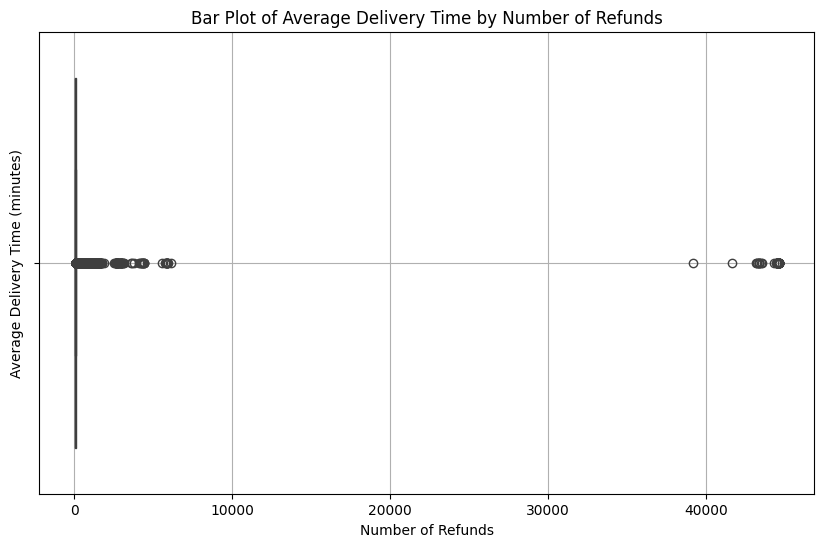

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Delivery_time_minutes')
plt.title('Bar Plot of Average Delivery Time by Number of Refunds')
plt.xlabel('Number of Refunds')
plt.ylabel('Average Delivery Time (minutes)')
plt.grid(True)
plt.show()

In [ ]:
Q1 = df['Delivery_time_minutes'].quantile(0.25)
Q3 = df['Delivery_time_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
filtered_df = df[(df['Delivery_time_minutes'] >= lower_bound) & (df['Delivery_time_minutes'] <= upper_bound)]

In [ ]:
df.head()

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Delivery_time_minutes
0,2024-01-14 20:27:45,2024-01-14 20:27:45,2024-01-14 20:39:32,2024-01-14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,24.300000
1,2024-01-07 20:16:28,2024-01-07 20:16:28,2024-01-07 20:36:00,2024-01-07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,32.566667
2,2024-01-13 19:35:09,2024-01-13 19:35:09,2024-01-13 20:28:16,2024-01-13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,77.583333
3,2024-01-22 19:47:53,2024-01-22 19:47:53,2024-01-22 20:01:20,2024-01-22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,30.133333
4,2024-01-03 19:01:52,2024-01-03 19:01:52,2024-01-03 19:36:20,2024-01-03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,43.566667


To evaluate the app's performance in terms of successful deliveries, the number of new and returning customers was analyzed. This metric indirectly reflects the number of deliveries. The assumption here is that:

Number of Orders = Number of Deliveries
This analysis depicts the number of new and returning customers by region and introduces a metric to show the conversion rate of new customers to returning customers. This metric indicates how many orders are placed by new customers versus returning customers.

<ipython-input-11-10a0bbdd8dd5>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Delivery_Region', palette='Reds')


([0, 1, 2, 3],
 [Text(0, 0, 'Palo Alto'),
  Text(1, 0, 'Mountain View'),
  Text(2, 0, 'San Jose'),
  Text(3, 0, 'Unknown')])

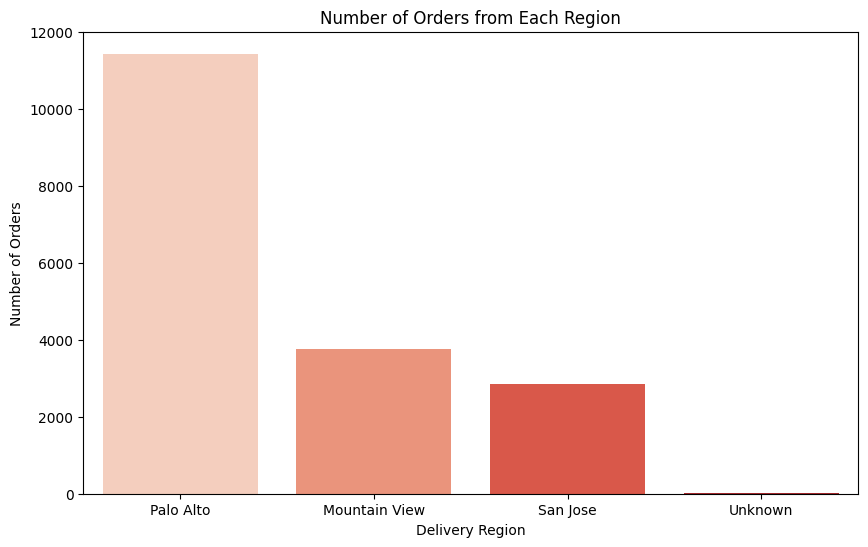

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Delivery_Region', palette='Reds')
plt.title('Number of Orders from Each Region')
plt.xlabel('Delivery Region')
plt.ylabel('Number of Orders')
plt.xticks(rotation=0)

## **Results and Insights**
### **Regional Performance**
* **Mountain View and Palo Alto:** Both regions are performing well, with customer retention metrics exceeding 4.2. This indicates strong customer retention. However, while Palo Alto attracts a significant number of new customers (2,123), Mountain View attracts fewer (720), suggesting that Mountain View excels in retention but struggles with customer acquisition.

* **San Jose:** This region is underperforming with a retention metric around 3.3. It struggles both in attracting new customers and retaining existing ones.



In [ ]:
df.sort_values(by=['Consumer_ID', 'Customer_placed_order_datetime'], inplace=True)
new_and_returning_counts = df.groupby(['Delivery_Region', 'Is_New']).size().unstack(fill_value=0)
new_and_returning_counts.columns = ['Returning_Customer', 'New_Customer']
new_and_returning_counts['New_to_Returning_Ratio'] = new_and_returning_counts['Returning_Customer'] / new_and_returning_counts['New_Customer']
print(new_and_returning_counts[['New_Customer', 'Returning_Customer', 'New_to_Returning_Ratio']])

                 New_Customer  Returning_Customer  New_to_Returning_Ratio
Delivery_Region                                                          
Mountain View             720                3040                4.222222
Palo Alto                2123                9310                4.385304
San Jose                  666                2193                3.292793


Customer Lifetime Value (CLV) measures the total value a customer brings over their entire relationship with the business, considering average order value, purchase frequency, and customer lifespan. Analysis shows that returning customers have at least twice the value compared to new customers. Notably, the CLV for the San Jose region is significantly lower than in other regions, highlighting it as an area needing improvement.

## **Recommendations:**

**Mountain View:**

Increase New Customer Acquisition: Since retention is strong, focus on strategies to attract new customers, such as local promotions and partnerships with popular local restaurants.


**Palo Alto:**

Sustain Retention Efforts: Continue current successful retention strategies while slightly enhancing efforts to acquire more new customers to maintain balance.


In [ ]:
df['Order_Value'] = df['Order_total'] - df['Refunded_amount'] - df['Amount_of_discount']
aov = df['Order_Value'].mean()
purchase_frequency = df.groupby('Consumer_ID').size().mean()
customer_value = aov * purchase_frequency
customer_lifespan = df.groupby('Consumer_ID')['Customer_placed_order_datetime'].apply(lambda x: (x.max() - x.min()).days / 30).mean()
clv = customer_value * customer_lifespan
new_customers = df[df['Is_New']]
returning_customers = df[~df['Is_New']]
new_customer_clv = (new_customers['Order_Value'].mean() * new_customers.groupby('Consumer_ID').size().mean()) * customer_lifespan
returning_customer_clv = (returning_customers['Order_Value'].mean() * returning_customers.groupby('Consumer_ID').size().mean()) * customer_lifespan

print(f"Overall CLV: {clv}")
print(f"New Customer CLV: {new_customer_clv}")
print(f"Returning Customer CLV: {returning_customer_clv}")


Overall CLV: 32.785373875257186
New Customer CLV: 17.811249660011676
Returning Customer CLV: 30.154382193385562


In [ ]:
clv_by_region = df.groupby('Delivery_Region').apply(lambda x: (x['Order_Value'].mean() * x.groupby('Consumer_ID').size().mean()) * x.groupby('Consumer_ID')['Customer_placed_order_datetime'].apply(lambda y: (y.max() - y.min()).days / 30).mean())
print(clv_by_region)

Delivery_Region
Mountain View    35.957293
Palo Alto        35.738516
San Jose         18.184279
dtype: float64


## **Conclusion**
By focusing on improving customer acquisition in Mountain View and retention in San Jose, DoorDash can increase its overall number of completed deliveries, aligning with its north star metric. Enhancing the Customer Lifetime Value in underperforming regions will also contribute to long-term business growth.

In [ ]:
customer_features = df.groupby('Consumer_ID').agg({
    'Order_Value': ['mean', 'sum', 'count'],
    'Customer_placed_order_datetime': ['max', 'min']
}).reset_index()

customer_features.columns = ['Consumer_ID', 'Avg_Order_Value', 'Total_Spend', 'Order_Count', 'Last_Order', 'First_Order']
customer_features['Customer_Tenure'] = (customer_features['Last_Order'] - customer_features['First_Order']).dt.days
customer_features.drop(['Last_Order', 'First_Order'], axis=1, inplace=True)

X = customer_features.drop(['Total_Spend', 'Consumer_ID'], axis=1)
y = customer_features['Total_Spend']

In [ ]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'RandomForest': RandomForestRegressor(n_estimators=1000, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=1000, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=1000, random_state=42)
}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name} Mean Squared Error: {mse}")
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"{name}  CV Mean Squared Error: {-cv_scores.mean()}")


Ridge Mean Squared Error: 49050.97686537359
Ridge  CV Mean Squared Error: 32642.85679989253
Lasso Mean Squared Error: 49108.12713736095
Lasso  CV Mean Squared Error: 32643.809038367202
RandomForest Mean Squared Error: 30729.604169006154
RandomForest  CV Mean Squared Error: 10283.629562308792
GradientBoosting Mean Squared Error: 26802.19367116921
GradientBoosting  CV Mean Squared Error: 7553.8719040565975
XGBoost Mean Squared Error: 13827.917266556837
XGBoost  CV Mean Squared Error: 4842.57175584785
